In [97]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns

pd.options.display.float_format = '{:,.3f}'.format

import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.dates import AutoDateFormatter, AutoDateLocator, YearLocator
import matplotlib.ticker as ticker
%matplotlib inline

# Univariate Plots

In [2]:
# load the dataset
#df = pd.read_csv("export-verified-contracts.csv",sep=",")
df = pd.read_csv("export-NetworkUtilization.csv",sep=",")

In [3]:
#reformat column names to non-unique, as the axis labels can always be renamed later
df["Date(UTC)"] = pd.to_datetime(df["Date(UTC)"])
df.columns = ["Date","TimeStamp","Value"]
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Week"] = df["Date"].dt.week

Text(0,0.5,'This can be renamed')

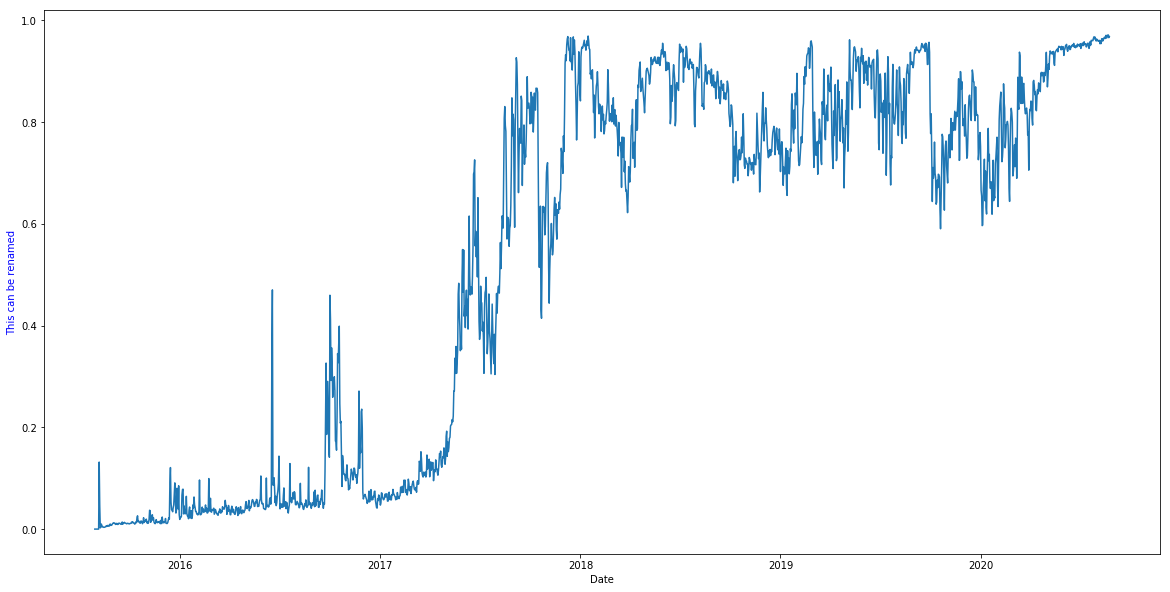

In [12]:
# time series plot
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.lineplot(x="Date", y="Value", data=df)
ax.set_ylabel('This can be renamed', color='b')

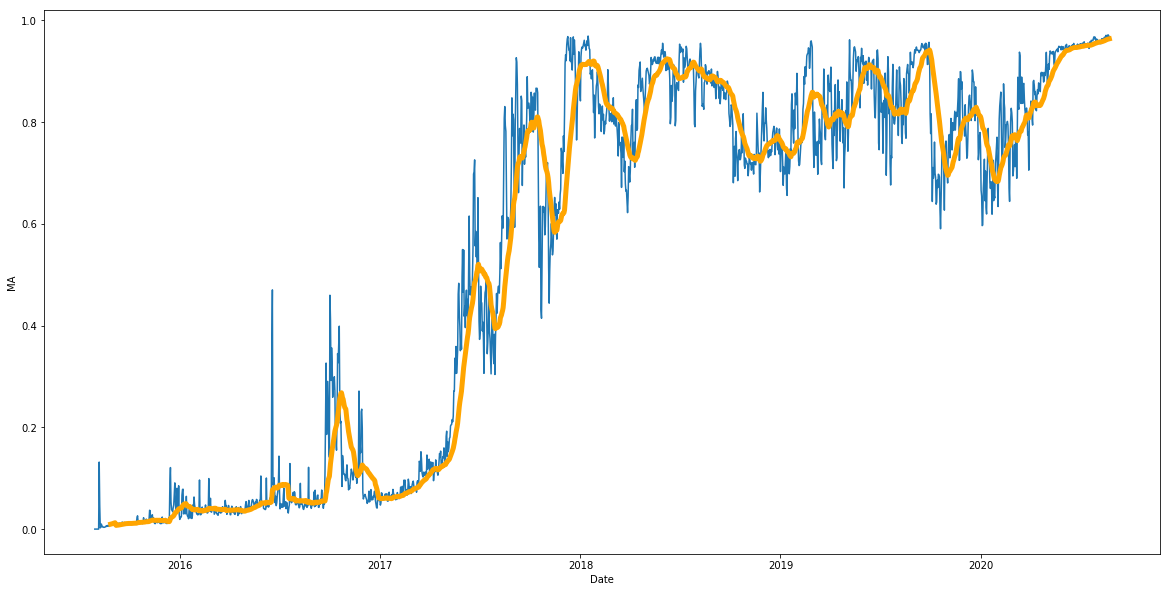

In [5]:
# time series with moving average (30 days)
plot_df = df.copy()
plot_df["MA"] = plot_df["Value"].rolling(30).mean() 
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.lineplot(x="Date", y="Value", data=plot_df)
ax = sns.lineplot(x="Date", y="MA", data=plot_df, linewidth=5, color="orange")

In [6]:
# table aggregated by average at year level
table = df[["Year","Value"]].groupby("Year").mean()

# you need to turn "Value" into it true meaningful name
table

,Value
Year,
2015,0.018
2016,0.076
2017,0.436
2018,0.834
2019,0.826
2020,0.864


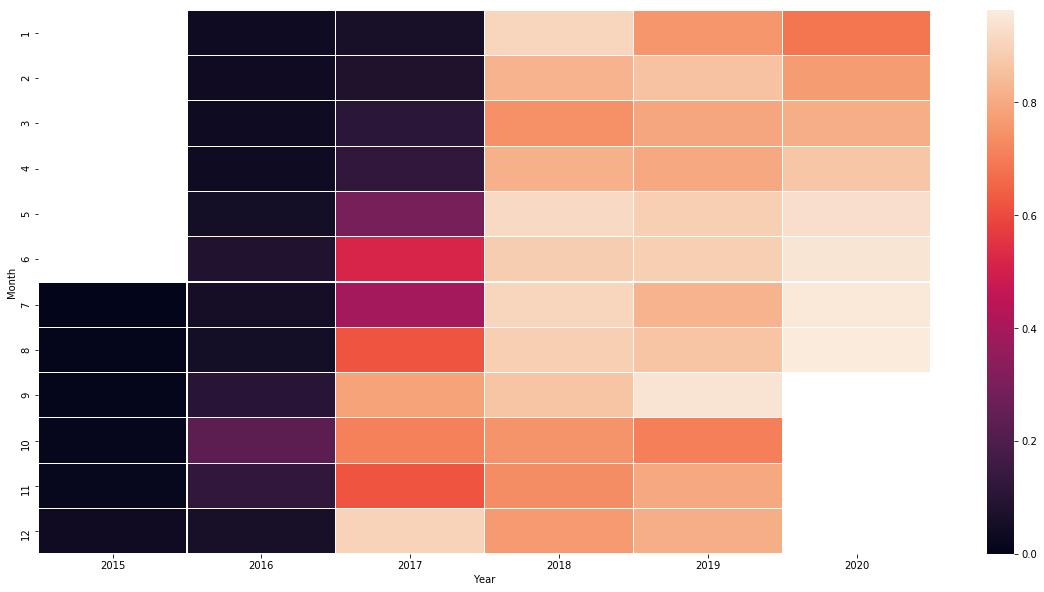

In [7]:
# heatmap by year and month
fig, ax = plt.subplots(figsize=(20,10))
plot_df = df[["Year","Month","Value"]].copy()
plot_df = plot_df.pivot_table(index="Month", columns="Year", values="Value",aggfunc="mean")
ax = sns.heatmap(plot_df, linewidths=0.1)

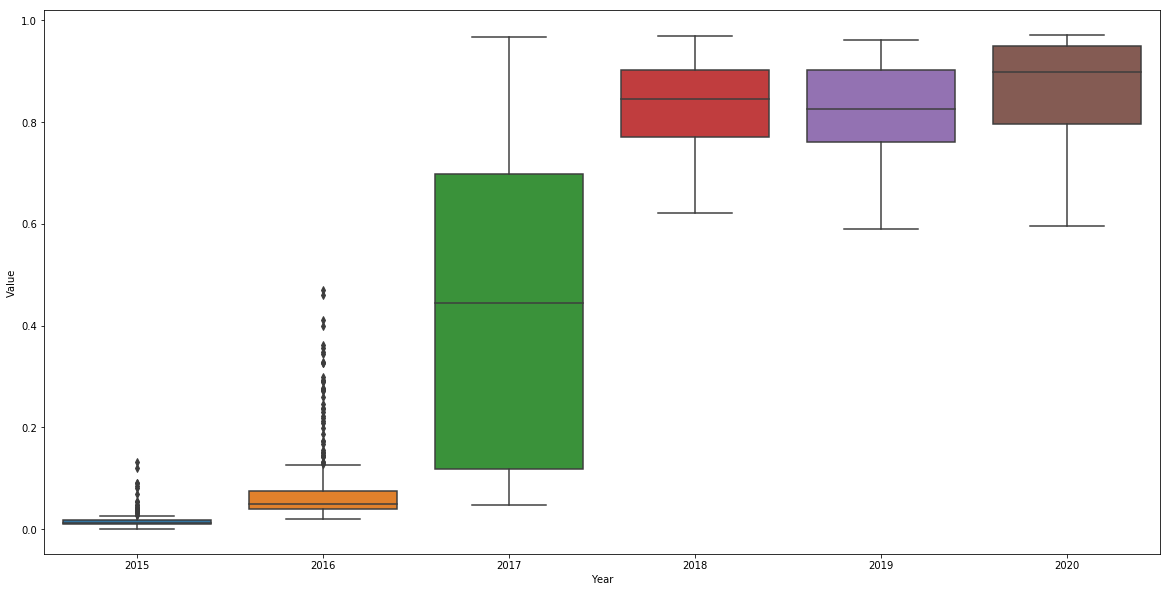

In [8]:
# Boxplots groupped by year
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.boxplot(x=df["Year"],y=df["Value"])

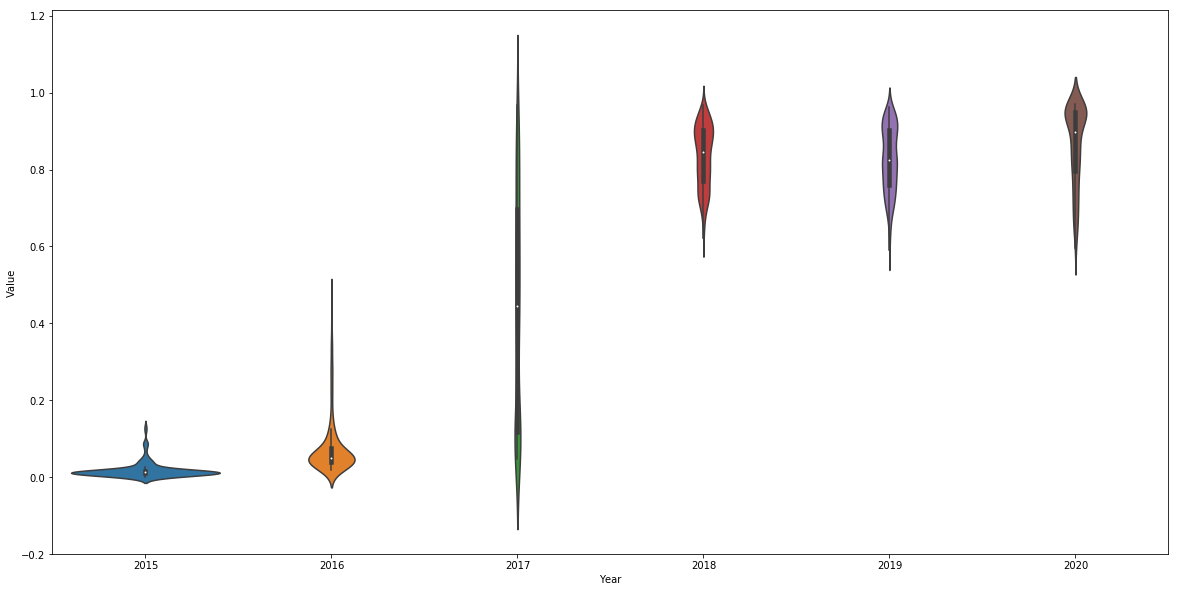

In [9]:
# violinplot groupped by year
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.violinplot(x=df["Year"],y=df["Value"])

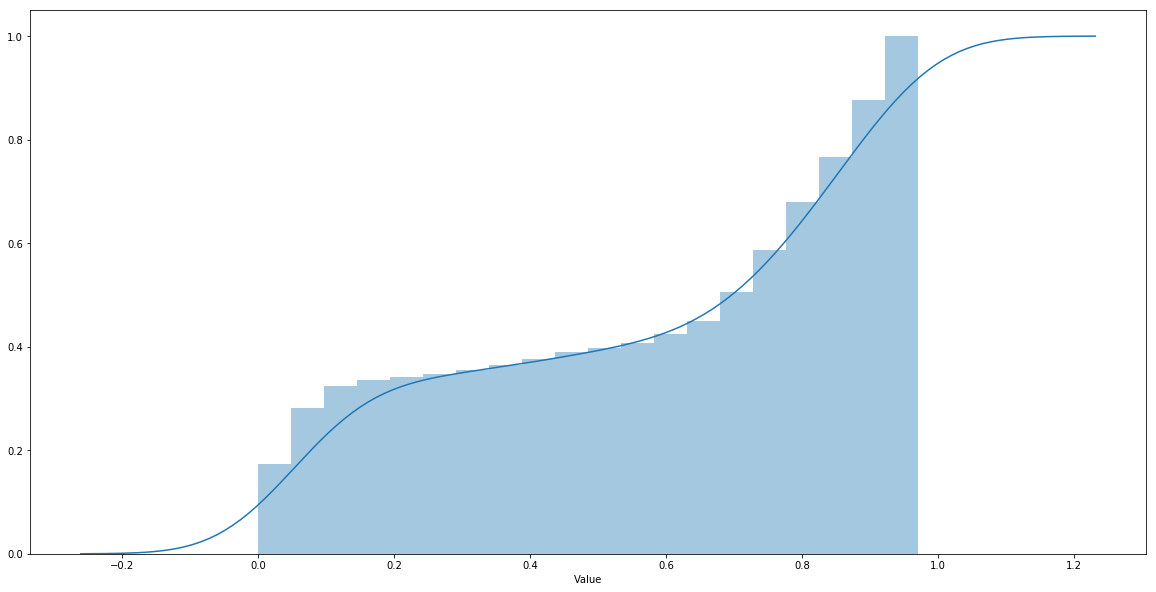

In [14]:
# ECDF
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.distplot(df["Value"], hist_kws={'cumulative': True}, kde_kws={'cumulative': True},bins=20)

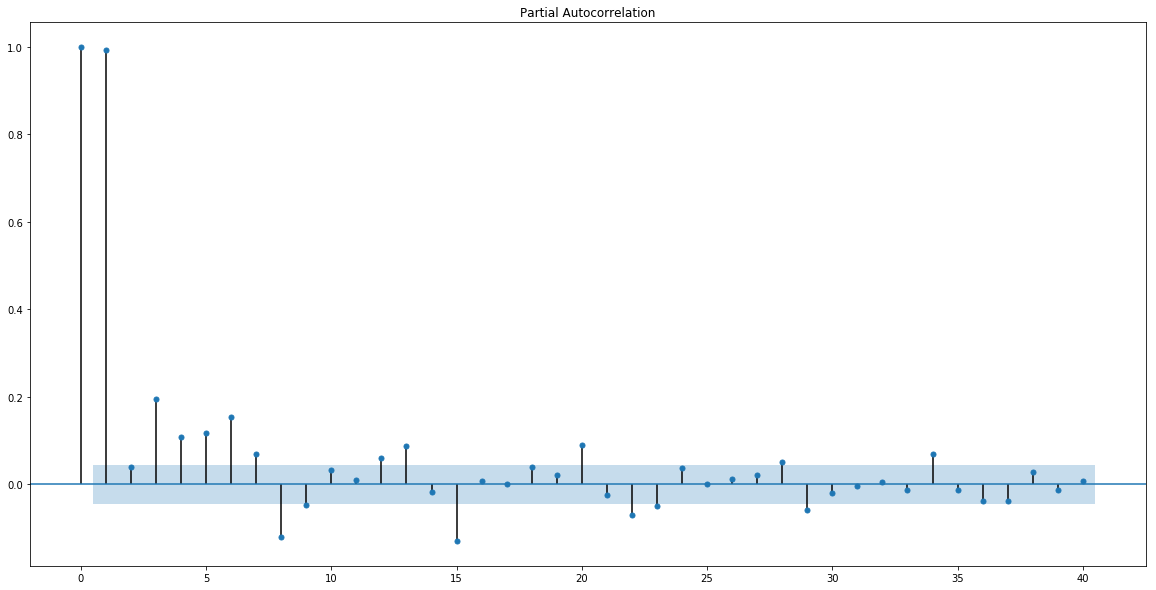

In [11]:
# partial auto correlation at daily
from statsmodels.graphics.tsaplots import plot_pacf
fig, ax = plt.subplots(figsize=(20,10))
plot_pacf(df["Value"].values, lags=40,ax=ax)
plt.show()

# Multivariate Plots

In [106]:
# load the dataset, don't need the date as UnixTimeStamp is given
data = []
to_include = ["export-verified-contracts.csv",
              "export-NetworkUtilization.csv",
              "export-GasUsed.csv",
              "export-GasLimit.csv",
              "export-TxGrowth.csv",
              "export-tokenerc-20txns.csv",
              "export-AddressCount.csv"]
for i in to_include:
    table = pd.read_csv(i,sep=",").iloc[:,1:]
    variable_name = i.split(".")[0].replace("export-","")
    table.columns = ["UnixTimeStamp",variable_name]
    data.append(table)

In [107]:
# construct a main df by inner merge on date (i.e. observations with missing values on any date are dropped)
df = data[0]
for i in range(1,len(data)):
    df = df.merge(data[i],on=["UnixTimeStamp"],how="inner")
df["Date"] = pd.to_datetime(df["UnixTimeStamp"],unit="s")

In [51]:
df.head()

,UnixTimeStamp,verified-contracts,NetworkUtilization,GasUsed,GasLimit,TxGrowth,tokenerc-20txns,AddressCount,Date
0,1458777600,12,0.057,1626133605,4714155,36947,4911,130970,2016-03-24
1,1458864000,2,0.046,1312008358,4713540,36762,2164,132066,2016-03-25
2,1458950400,5,0.046,1332524164,4722269,36646,5508,133107,2016-03-26
3,1459036800,1,0.029,825632165,4713640,29974,510,134131,2016-03-27
4,1459123200,1,0.042,1184635969,4713570,33613,4227,135514,2016-03-28


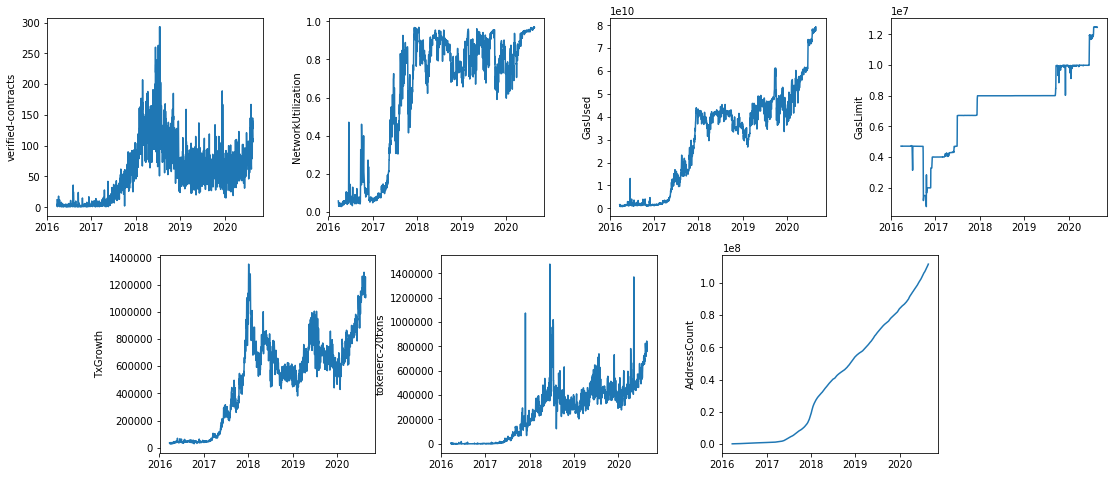

In [105]:
# multiple time series

fig = plt.subplots(figsize=(20, 8))

# Because there are 7 times series, I have to manually draw the frames to achieve better alignment.
gs = gridspec.GridSpec(2, 20, height_ratios=[1,1]) 
ax1 = plt.subplot(gs[0,0:4])
ax2 = plt.subplot(gs[0,5:9])
ax3 = plt.subplot(gs[0,10:14])
ax4 = plt.subplot(gs[0,15:19])
ax5 = plt.subplot(gs[1,2:6])
ax6 = plt.subplot(gs[1,7:11])
ax7 = plt.subplot(gs[1,12:16])
axes = [ax1,ax2,ax3,ax4,ax5,ax6,ax7]

# plot in every subplot a time series
xtick_locator = AutoDateLocator()
xtick_formatter = AutoDateFormatter(xtick_locator)

for i in range(0,7):
    axes[i].plot(df["Date"],df.iloc[:,i+1])
    axes[i].xaxis.set_major_locator(YearLocator())
    axes[i].set_ylabel(df.iloc[:,i+1].name)

In [109]:
# correlation matrix
# maybe the correlation should be run on transformed variables (i.e. de-trended or first difference)
corr = df[["verified-contracts","NetworkUtilization","GasUsed","GasLimit","TxGrowth","tokenerc-20txns","AddressCount"]].corr()
corr

,verified-contracts,NetworkUtilization,GasUsed,GasLimit,TxGrowth,tokenerc-20txns,AddressCount
verified-contracts,1.000,0.707,0.646,0.592,0.683,0.642,0.442
NetworkUtilization,0.707,1.000,0.897,0.831,0.902,0.801,0.725
GasUsed,0.646,0.897,1.000,0.942,0.937,0.902,0.906
GasLimit,0.592,0.831,0.942,1.000,0.866,0.845,0.895
TxGrowth,0.683,0.902,0.937,0.866,1.000,0.823,0.764
tokenerc-20txns,0.642,0.801,0.902,0.845,0.823,1.000,0.858
AddressCount,0.442,0.725,0.906,0.895,0.764,0.858,1.000


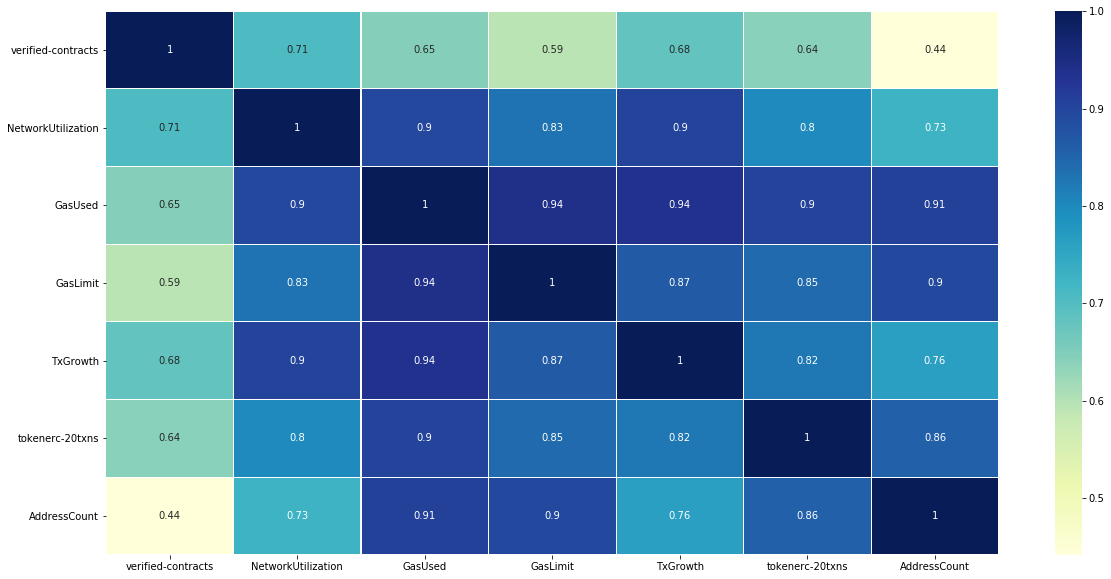

In [113]:
# correlation heatmap
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.heatmap(corr, linewidths=0.1, cmap="YlGnBu", annot=True)